# Cardiac MRI Classification - Sequential Training

## 1. Imports and Setup

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet152V2, DenseNet201, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Multiply, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import math

# --- Configuration ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 128 # Adjust based on GPU memory
EPOCHS = 10      # Adjust as needed, 10 is for quicker testing
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5
VALIDATION_SPLIT = 0.2 # Using 20% for validation, like OG files

# --- Paths ---
BASE_DATA_DIR = '/content/cad_cardiac_mri' # Raw download path & Source for Generators
CHECKPOINT_DIR = 'checkpoints_sequential_og_split' # Directory for saving best models

# --- Check GPU ---
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if tf.config.list_physical_devices('GPU'):
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("No GPU detected, running on CPU.")

# --- Ensure necessary directories exist ---
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- Install necessary packages ---
!pip install keras-tuner -q # Only if using HPO later

TensorFlow version: 2.18.0
GPU Available: True
Num GPUs Available:  1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.4 MB/s eta 0:00:00


In [2]:
# Dictionary to store results for summary
results_summary = {}

## 2. Kaggle API Setup & Dataset Download
*Run this cell once to set up Kaggle credentials and download the data.*

In [3]:
# Upload your kaggle.json file when prompted
try:
    from google.colab import files
    print("Upload your kaggle.json file")
    files.upload()

    # Configure Kaggle credentials
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 600)

    # Download the dataset
    print("Downloading dataset...")
    # Use quiet flag (-q) to reduce download noise
    os.system(f'kaggle datasets download danialsharifrazi/cad-cardiac-mri-dataset --unzip -p {BASE_DATA_DIR} -q')
    print(f"Dataset downloaded and unzipped to {BASE_DATA_DIR}")

except ModuleNotFoundError:
    print("Not in Colab environment or google.colab not available. Skipping Kaggle setup.")
    print("Please ensure the dataset is available at:", BASE_DATA_DIR)
except FileNotFoundError:
    print("kaggle.json not uploaded. Skipping Kaggle setup.")
    print("Please ensure the dataset is available at:", BASE_DATA_DIR)
except Exception as e:
    print(f"An error occurred during Kaggle setup/download: {e}")
    print("Please ensure the dataset is available at:", BASE_DATA_DIR)

Upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset downloaded and unzipped to /content/cad_cardiac_mri


## 3. Dataset Flattening
*This cell moves images from potential subdirectories (like patient IDs) directly into the 'Normal' and 'Sick' folders. Run once after download.*
*(Same as before)*

In [4]:
print("Flattening dataset structure...")
flattening_done = False
for class_folder in ["Normal", "Sick"]:
    class_path = os.path.join(BASE_DATA_DIR, class_folder)
    if not os.path.exists(class_path):
        print(f"Warning: Directory not found - {class_path}. Skipping flattening for this class.")
        continue

    subdirs = [d for d in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, d))]

    if not subdirs:
        print(f"No subdirectories found in {class_path}. Assuming already flat.")
        continue # Skip if no subdirectories

    print(f"Processing subdirectories in {class_path}...")
    for root, dirs, files in os.walk(class_path, topdown=False): # Walk bottom-up
        if root == class_path: # Skip the top-level directory itself in the loop
            continue

        for file in files:
            # Check if file looks like an image and is not already at the top level
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                source = os.path.join(root, file)
                destination = os.path.join(class_path, file) # Destination is the top-level class folder

                # Avoid overwriting if a file with the same name exists at the destination
                if not os.path.exists(destination):
                    try:
                        shutil.move(source, destination)
                        flattening_done = True
                    except Exception as e:
                        print(f"Error moving {source} to {destination}: {e}")
                # else:
                #     print(f"Skipping move for {file}, already exists at destination.") # Optional: uncomment for verbosity

        # Attempt to remove the now-empty directory
        try:
             if not os.listdir(root): # Check again if empty
                 os.rmdir(root)
        except OSError as e:
            print(f"Could not remove directory {root}: {e}")


if flattening_done:
    print("Flattening complete. Images moved to top-level Normal/ and Sick/ directories.")
else:
    print("No files needed moving, or source directories were missing.")

Flattening dataset structure...
Processing subdirectories in /content/cad_cardiac_mri/Normal...
Processing subdirectories in /content/cad_cardiac_mri/Sick...
Flattening complete. Images moved to top-level Normal/ and Sick/ directories.


## 4. Data Generators and Class Weights (OG Split Method)
*Creates ImageDataGenerators using `validation_split` for training and validation. Calculates class weights.*

In [5]:
def create_data_generators_og_split(base_dir_path, img_height, img_width, batch_size, validation_split):
    """Creates data generators using validation_split for train and validation sets."""
    if not os.path.exists(base_dir_path):
         raise FileNotFoundError(f"Base data directory not found: {base_dir_path}")

    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split # Use validation_split here
    )

    # Validation data generator (only rescaling)
    # Also needs validation_split to correctly identify the subset
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split # Use validation_split here
    )

    try:
        print("Creating Training Generator...")
        train_generator = train_datagen.flow_from_directory(
            base_dir_path,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary',
            color_mode='rgb', # Ensure RGB
            subset='training', # Specify this is the training subset
            seed=1337, # Use seed for reproducibility if desired
            shuffle=True # Shuffle training data
        )

        print("Creating Validation Generator...")
        val_generator = val_datagen.flow_from_directory(
            base_dir_path,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary',
            color_mode='rgb', # Ensure RGB
            subset='validation', # Specify this is the validation subset
            seed=1337,
            shuffle=False # No need to shuffle validation/test
        )

        # --- Print Class Distribution ---
        print("\n--- Class Distribution (Detected by Generators) ---")
        if train_generator.classes is not None:
            train_counts = np.bincount(train_generator.classes)
            print(f"Training set: {train_generator.samples} images")
            for cls, count in enumerate(train_counts):
                 print(f"  Class {cls} ({list(train_generator.class_indices.keys())[cls]}): {count}")
            if len(train_counts) > 1 and train_counts[1] > 0: # Avoid division by zero
                print(f"   Normal/Sick Ratio: {train_counts[0]/train_counts[1]:.1f} : 1")
        else:
            print("Warning: Could not determine training set class counts.")

        if val_generator.classes is not None:
            val_counts = np.bincount(val_generator.classes)
            print(f"Validation set: {val_generator.samples} images")
            for cls, count in enumerate(val_counts):
                 print(f"  Class {cls} ({list(val_generator.class_indices.keys())[cls]}): {count}")
        else:
            print("Warning: Could not determine validation set class counts.")


        return train_generator, val_generator
    except Exception as e:
        print(f"Error creating data generators: {e}")
        raise

def calculate_class_weights_from_generator(generator):
    """Calculates class weights based on a generator's classes."""
    try:
        labels = generator.classes
        if labels is None:
             print("Warning: Generator classes attribute is None. Attempting to iterate.")
             # Fallback: Iterate through the generator once to get labels (slow)
             labels = []
             steps = math.ceil(generator.samples / generator.batch_size)
             for i in range(steps):
                 _, batch_labels = generator.next()
                 labels.extend(batch_labels)
             labels = np.array(labels[:generator.samples]) # Trim excess if needed

        if labels.size == 0:
            print("Error: No labels found to calculate class weights.")
            return None

        weights = class_weight.compute_class_weight(
            'balanced',
            classes=np.unique(labels),
            y=labels
        )
        # Create a dictionary mapping class indices to weights
        class_weights_dict = {i : weights[i] for i in range(len(weights))}

        print("\n--- Class Weights ---")
        class_indices = generator.class_indices
        inv_map = {v: k for k, v in class_indices.items()} # Map index back to name
        for idx, weight in class_weights_dict.items():
            print(f"Class '{inv_map[idx]}' (Index {idx}): Weight {weight:.4f}")
        return class_weights_dict

    except Exception as e:
        print(f"Error calculating class weights: {e}")
        return None

# Create generators using the OG split method
try:
    train_generator, val_generator = create_data_generators_og_split(
        BASE_DATA_DIR, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, VALIDATION_SPLIT
    )

    # Calculate class weights from the training generator
    class_weights = calculate_class_weights_from_generator(train_generator)
    if class_weights is None:
        print("Warning: Could not calculate class weights. Training will proceed without them.")

    # Store validation labels and steps for evaluation (since no separate test set)
    y_true_eval = val_generator.classes
    eval_steps = math.ceil(val_generator.samples / val_generator.batch_size)

except Exception as e:
    raise Exception(f"Failed to initialize data processing: {e}")

# Display one batch of augmented images from train generator
# images, labels = next(train_generator)
# plt.figure(figsize=(12, 12))
# for i in range(min(9, BATCH_SIZE)): # Display up to 9 images
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i])
#     plt.title(f"Label: {'Sick' if labels[i] > 0.5 else 'Normal'}")
#     plt.axis('off')
# plt.suptitle("Sample Augmented Training Images")
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

Creating Training Generator...
Found 50741 images belonging to 2 classes.
Creating Validation Generator...
Found 12684 images belonging to 2 classes.

--- Class Distribution (Detected by Generators) ---
Training set: 50741 images
  Class 0 (Normal): 30052
  Class 1 (Sick): 20689
   Normal/Sick Ratio: 1.5 : 1
Validation set: 12684 images
  Class 0 (Normal): 7512
  Class 1 (Sick): 5172

--- Class Weights ---
Class 'Normal' (Index 0): Weight 0.8442
Class 'Sick' (Index 1): Weight 1.2263


## 5. Utility Functions (Evaluation & Plotting)
*Modified to evaluate on the validation set.*

In [6]:
def evaluate_model(model, eval_gen, eval_steps, y_true, model_name):
    """Evaluates the model on the provided generator (validation set in this case)."""
    print(f"\n--- Evaluating {model_name} on Validation Set ---")
    eval_gen.reset() # Ensure generator starts from the beginning
    try:
        # Evaluate loss and accuracy using the generator
        loss, accuracy = model.evaluate(eval_gen, steps=eval_steps, verbose=0)
        print(f"Validation Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")

        eval_gen.reset() # Reset again before predict
        y_pred_prob = model.predict(eval_gen, steps=eval_steps, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten() # Flatten for metrics

        # Ensure y_pred has the same length as y_true
        if len(y_pred) > len(y_true):
            y_pred = y_pred[:len(y_true)]

        print("\nClassification Report (Validation Set):")
        class_names = list(eval_gen.class_indices.keys())
        report_str = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        print(report_str)

        balanced_acc = balanced_accuracy_score(y_true, y_pred)
        print(f"Balanced Accuracy (Validation Set): {balanced_acc:.4f}")

        # Plot Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, class_names, title=f'{model_name} Confusion Matrix (Validation)')

        # Store key results
        results_summary[model_name] = {
            'Accuracy': accuracy,
            'Balanced Accuracy': balanced_acc,
            'Loss': loss,
            'Precision (Normal)': report_dict['Normal']['precision'],
            'Recall (Normal)': report_dict['Normal']['recall'],
            'F1-Score (Normal)': report_dict['Normal']['f1-score'],
            'Precision (Sick)': report_dict['Sick']['precision'],
            'Recall (Sick)': report_dict['Sick']['recall'],
            'F1-Score (Sick)': report_dict['Sick']['f1-score']
        }
        return report_dict # Return dict for potential further use

    except Exception as e:
        print(f"Error during evaluation of {model_name}: {e}")
        results_summary[model_name] = {'Error': str(e)}
        return None

# plot_confusion_matrix and plot_training_history remain the same as before
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_training_history(history, model_name):
    """Plots training and validation accuracy/loss."""
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        ax1.plot(history.history['accuracy'], label='Train Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title(f'{model_name} Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)

        # Loss plot
        ax2.plot(history.history['loss'], label='Train Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title(f'{model_name} Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()
        fig.savefig(f"{model_name}_training_history.png") # Save the plot
    except KeyError as e:
        print(f"Warning: Could not plot history for {model_name}. Key missing: {e}")
    except Exception as e:
        print(f"Error plotting history for {model_name}: {e}")

## 6. Model Building Functions
*(Same as before)*

In [7]:
# --- Base Models ---
def build_transfer_model(base_model_cls, input_shape, dropout_rate, learning_rate, name):
    """Helper function to build transfer learning models."""
    base_model = base_model_cls(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False # Freeze base layers

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name=name)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_mobilenetv2(input_shape=INPUT_SHAPE, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    return build_transfer_model(MobileNetV2, input_shape, dropout_rate, learning_rate, "MobileNetV2_Baseline")

def build_resnet152v2(input_shape=INPUT_SHAPE, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    return build_transfer_model(ResNet152V2, input_shape, dropout_rate, learning_rate, "ResNet152V2_Baseline")

def build_densenet201(input_shape=INPUT_SHAPE, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    return build_transfer_model(DenseNet201, input_shape, dropout_rate, learning_rate, "DenseNet201_Baseline")

def build_inceptionv3(input_shape=INPUT_SHAPE, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    # InceptionV3 requires input size >= 75x75. Adjust if necessary, but 128x128 is fine.
    return build_transfer_model(InceptionV3, input_shape, dropout_rate, learning_rate, "InceptionV3_Baseline")


# --- Attention Model ---
def build_attention_model(base_model_name='mobilenetv2', input_shape=INPUT_SHAPE, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    """Builds a model with a simple spatial attention mechanism."""
    if base_model_name.lower() == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name.lower() == 'resnet152v2':
        base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name.lower() == 'densenet201':
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name.lower() == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported base model for attention: {base_model_name}")

    base_model.trainable = False # Freeze base layers

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Simple Spatial Attention (Convolutional Attention Map)
    attention_probs = Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='attention_map')(x)
    attention_mul = Multiply(name='attention_multiply')([x, attention_probs])

    # Continue with the rest of the model
    x_att = GlobalAveragePooling2D()(attention_mul)
    x_att = Dropout(dropout_rate)(x_att)
    outputs = Dense(1, activation='sigmoid')(x_att)

    model_name_att = f"{base_model_name.capitalize()}_Attention"
    model = Model(inputs, outputs, name=model_name_att)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## 7. Baseline Model Training & Evaluation
*Train and evaluate each base model sequentially using the OG split.*

### 7.1 MobileNetV2 Baseline


--- Training MobileNetV2_Baseline_OG_Split ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.5279 - loss: 0.8980
Epoch 1: val_loss improved from inf to 0.64316, saving model to checkpoints_sequential_og_split/MobileNetV2_Baseline_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 281s 669ms/step - accuracy: 0.5279 - loss: 0.8978 - val_accuracy: 0.6335 - val_loss: 0.6432 - learning_rate: 1.0000e-04
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.6260 - loss: 0.7027
Epoch 2: val_loss improved from 0.64316 to 0.58046, saving model to checkpoints_sequential_og_split/MobileNetV2_Baseline_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 251s 633ms/step - accuracy: 0.6260 - loss: 0.7027 - val_accuracy: 0.7015 - val_loss: 0.5805 - learning_rate: 1.0000e-04
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.6663 - loss: 0.6296
Epoch 3: val_loss improved from 0.58046 to 0.56733, saving model to checkpoints_sequential_og_split/MobileNetV2_Baseline_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 251s 

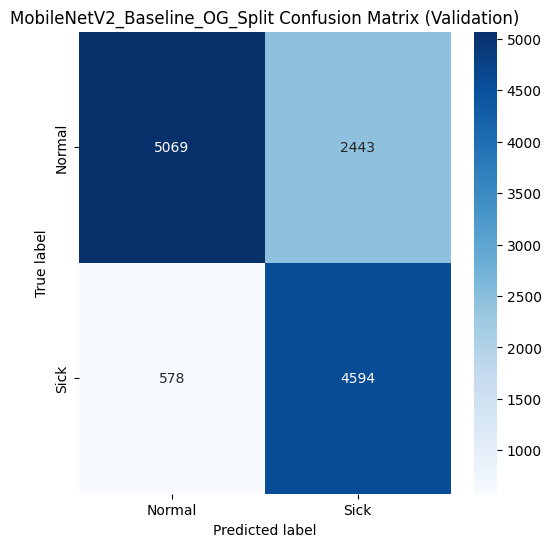

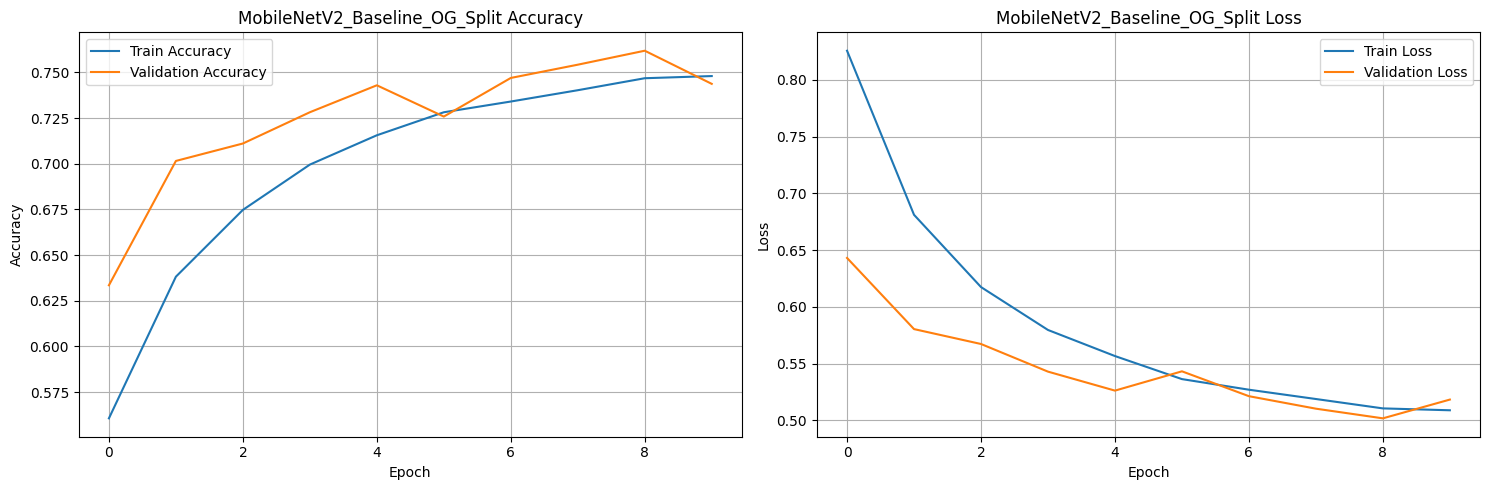

In [8]:
model_name = "MobileNetV2_Baseline_OG_Split"
print(f"\n--- Training {model_name} ---")

model_mobilenet_base = build_mobilenetv2()

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.keras")
callbacks_base = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
]

history_mobilenet_base = model_mobilenet_base.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_base,
    class_weight=class_weights, # Apply class weights
    verbose=1
)

# Load the best model saved by ModelCheckpoint
print(f"\nLoading best model for {model_name} from {checkpoint_path}")
best_model_mobilenet_base = load_model(checkpoint_path)

# Evaluate the best model on the VALIDATION SET
report_mobilenet_base = evaluate_model(best_model_mobilenet_base, val_generator, eval_steps, y_true_eval, model_name)

# Plot history of the best model run (restored by EarlyStopping)
plot_training_history(history_mobilenet_base, model_name)

### 7.2 ResNet152V2 Baseline


--- Training ResNet152V2_Baseline_OG_Split ---
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.5510 - loss: 0.9603
Epoch 1: val_loss improved from inf to 0.61618, saving model to checkpoints_sequential_og_split/ResNet152V2_Baseline_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 297s 683ms/step - accuracy: 0.5511 - loss: 0.9601 - val_accuracy: 0.6548 - val_loss: 0.6162 - learning_rate: 1.0000e-04
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.6384 - loss: 0.7207
Epoch 2: val_loss improved from 0.61618 to 0.55352, saving model to checkpoints_sequential_og_split/ResNet152V2_Baseline_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 253s 637ms/step - accuracy: 0.6384 - loss: 0.7206 - val_accuracy: 0.7004 - val_loss: 0.5535 - learning_rate: 1.0000e-04
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.6736 - loss: 0.6377
Epoch 3: val_loss improved from 0.55352 to 0.52377, saving model to c

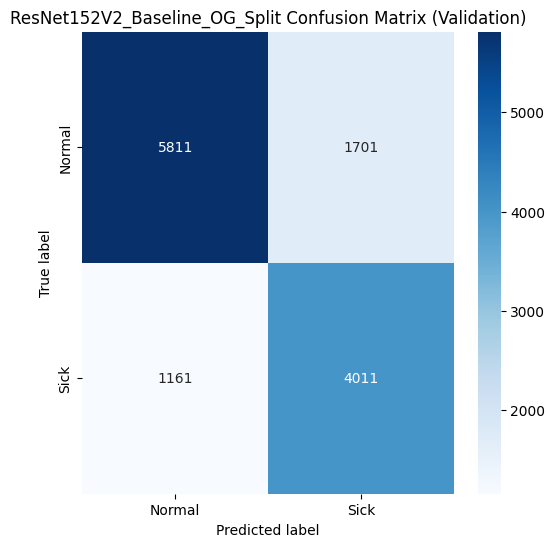

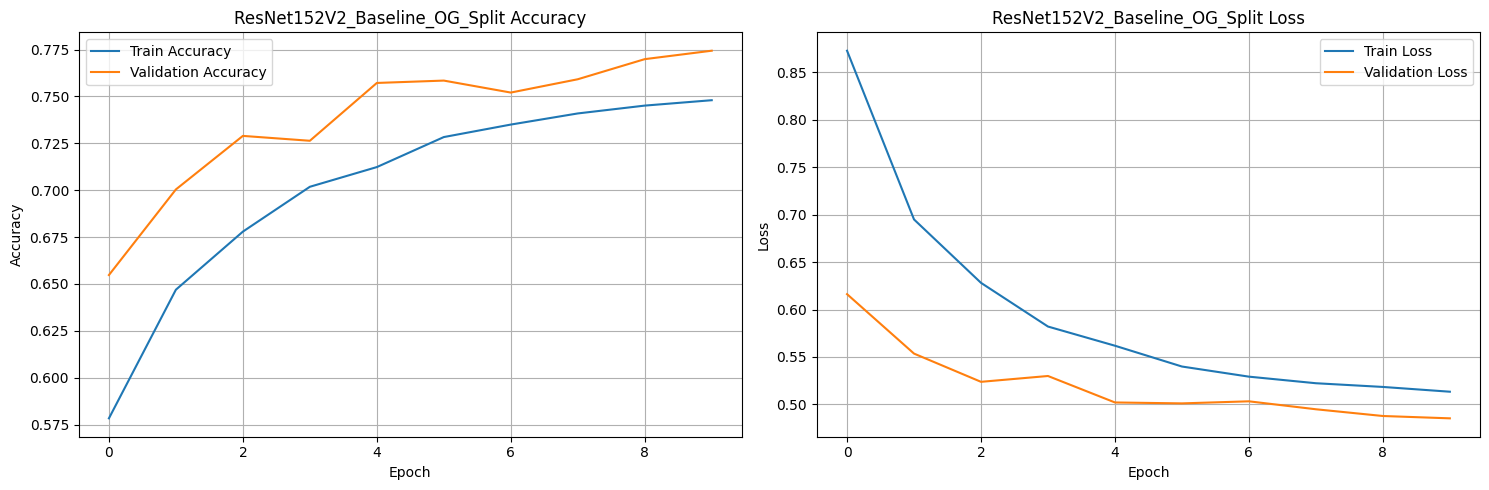

In [9]:
model_name = "ResNet152V2_Baseline_OG_Split"
print(f"\n--- Training {model_name} ---")

model_resnet_base = build_resnet152v2()

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.keras")
callbacks_base = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
]

history_resnet_base = model_resnet_base.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_base,
    class_weight=class_weights,
    verbose=1
)

print(f"\nLoading best model for {model_name} from {checkpoint_path}")
best_model_resnet_base = load_model(checkpoint_path)
report_resnet_base = evaluate_model(best_model_resnet_base, val_generator, eval_steps, y_true_eval, model_name)
plot_training_history(history_resnet_base, model_name)

### 7.3 DenseNet201 Baseline


--- Training DenseNet201_Baseline_OG_Split ---
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.5086 - loss: 0.9749
Epoch 1: val_loss improved from inf to 0.62119, saving model to checkpoints_sequential_og_split/DenseNet201_Baseline_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 350s 773ms/step - accuracy: 0.5087 - loss: 0.9746 - val_accuracy: 0.6280 - val_loss: 0.6212 - learning_rate: 1.0000e-04
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6249 - loss: 0.7033
Epoch 2: val_loss improved from 0.62119 to 0.56769, saving model to checkpoints_sequential_og_split/DenseNet201_Baseline_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 254s 639ms/step - accuracy: 0.6250 - loss: 0.7032 - val_accuracy: 0.6742 - val_loss: 0.5677 - learning_rate: 1.0000e-04
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6572 - loss: 0.6405
Epoch 3: val_loss improved from 0.56769 to 0.55286, saving model to che

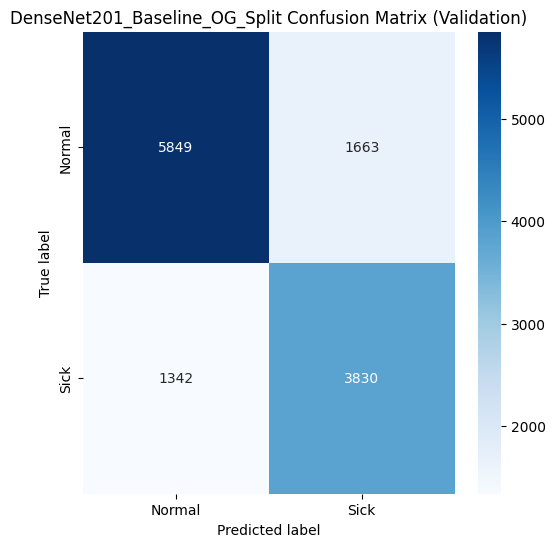

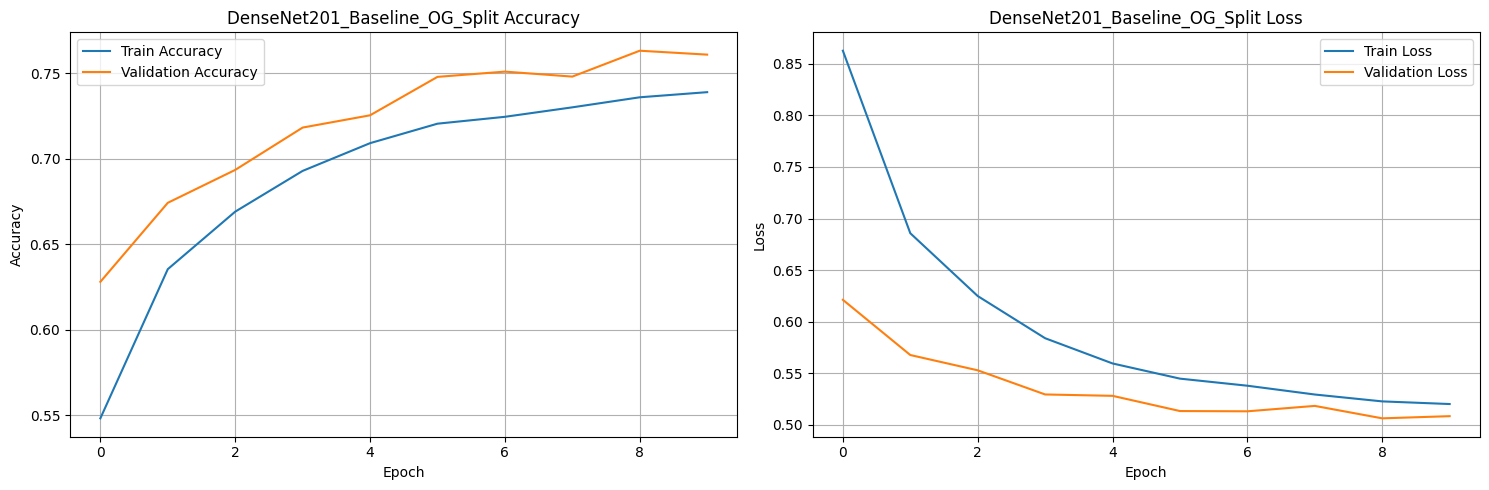

In [10]:
model_name = "DenseNet201_Baseline_OG_Split"
print(f"\n--- Training {model_name} ---")

model_densenet_base = build_densenet201()

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.keras")
callbacks_base = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
]

history_densenet_base = model_densenet_base.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_base,
    class_weight=class_weights,
    verbose=1
)

print(f"\nLoading best model for {model_name} from {checkpoint_path}")
best_model_densenet_base = load_model(checkpoint_path)
report_densenet_base = evaluate_model(best_model_densenet_base, val_generator, eval_steps, y_true_eval, model_name)
plot_training_history(history_densenet_base, model_name)

### 7.4 InceptionV3 Baseline


--- Training InceptionV3_Baseline_OG_Split ---
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.5338 - loss: 1.1749
Epoch 1: val_loss improved from inf to 0.72206, saving model to checkpoints_sequential_og_split/InceptionV3_Baseline_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 281s 672ms/step - accuracy: 0.5339 - loss: 1.1746 - val_accuracy: 0.5957 - val_loss: 0.7221 - learning_rate: 1.0000e-04
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6122 - loss: 0.8859
Epoch 2: val_loss improved from 0.72206 to 0.64955, saving model to checkpoints_sequential_og_split/InceptionV3_Baseline_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 252s 634ms/step - accuracy: 0.6122 - loss: 0.8858 - val_accuracy: 0.6366 - val_loss: 0.6496 - learning_rate: 1.0000e-04
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.6435 - loss: 0.7738
Epoch 3: val_loss improved from 0.64955 to 0.61234, saving model to che

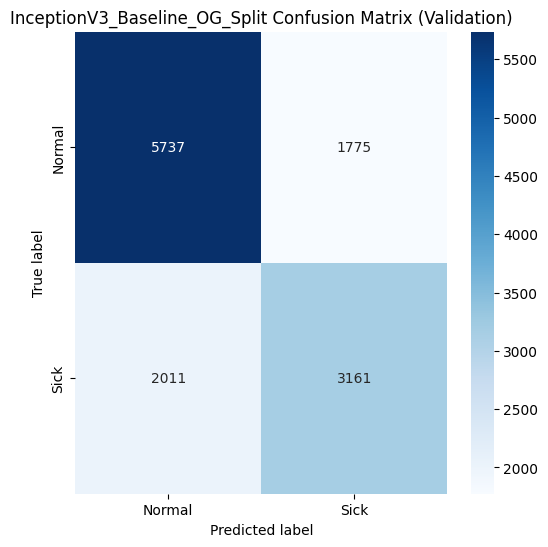

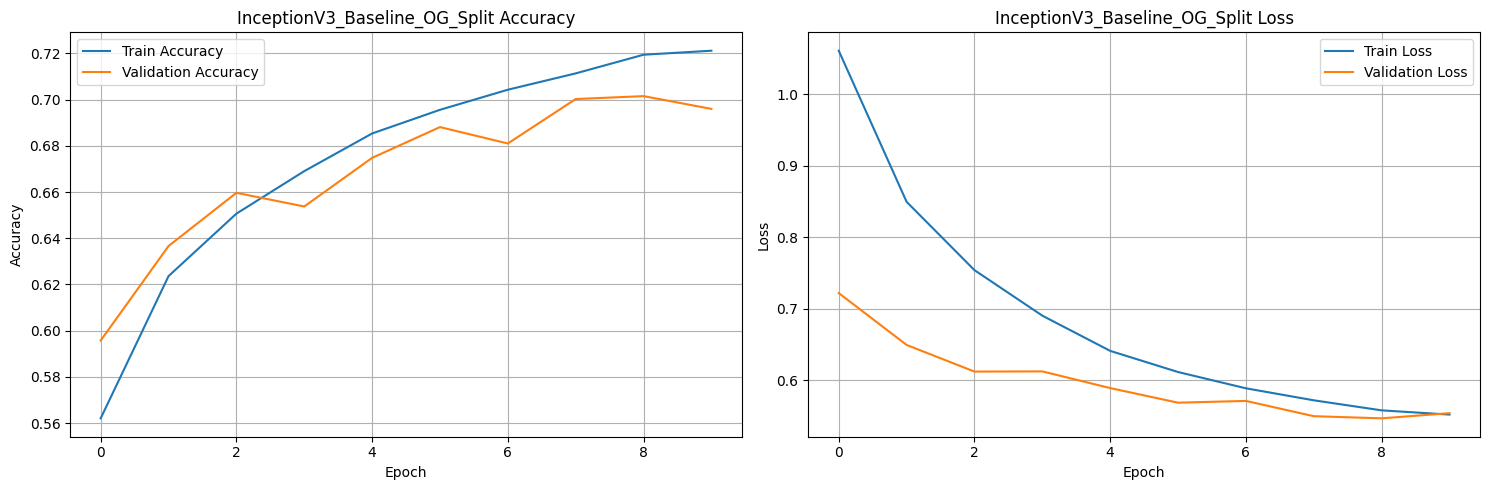

In [11]:
model_name = "InceptionV3_Baseline_OG_Split"
print(f"\n--- Training {model_name} ---")

model_inception_base = build_inceptionv3()

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.keras")
callbacks_base = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
]

history_inception_base = model_inception_base.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_base,
    class_weight=class_weights,
    verbose=1
)

print(f"\nLoading best model for {model_name} from {checkpoint_path}")
best_model_inception_base = load_model(checkpoint_path)
report_inception_base = evaluate_model(best_model_inception_base, val_generator, eval_steps, y_true_eval, model_name)
plot_training_history(history_inception_base, model_name)

## 8. Attention Model Training & Evaluation
*Train and evaluate each model with the added attention mechanism using the OG split.*

### 8.1 MobileNetV2 + Attention


--- Training Mobilenetv2_Attention_OG_Split ---
Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.5222 - loss: 0.7126
Epoch 1: val_loss improved from inf to 0.65401, saving model to checkpoints_sequential_og_split/Mobilenetv2_Attention_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 264s 646ms/step - accuracy: 0.5223 - loss: 0.7126 - val_accuracy: 0.6267 - val_loss: 0.6540 - learning_rate: 1.0000e-04
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.6207 - loss: 0.6490
Epoch 2: val_loss improved from 0.65401 to 0.60745, saving model to checkpoints_sequential_og_split/Mobilenetv2_Attention_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 250s 629ms/step - accuracy: 0.6207 - loss: 0.6490 - val_accuracy: 0.6813 - val_loss: 0.6075 - learning_rate: 1.0000e-04
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.6696 - loss: 0.5925
Epoch 3: val_loss improved from 0.60745 to 0.57964, saving model to checkpoints_sequential_og_split/Mobilenetv2_Attenti

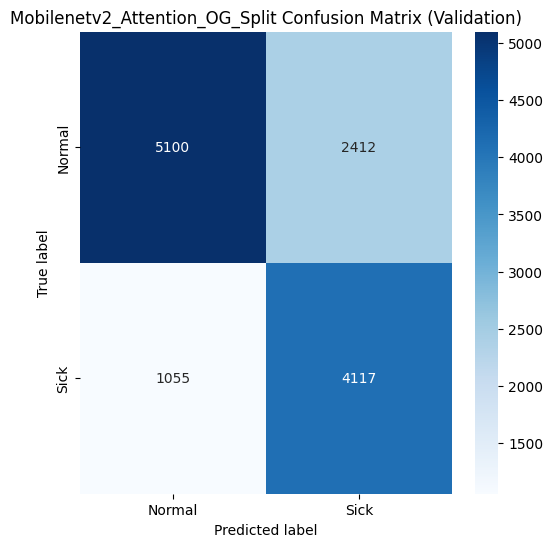

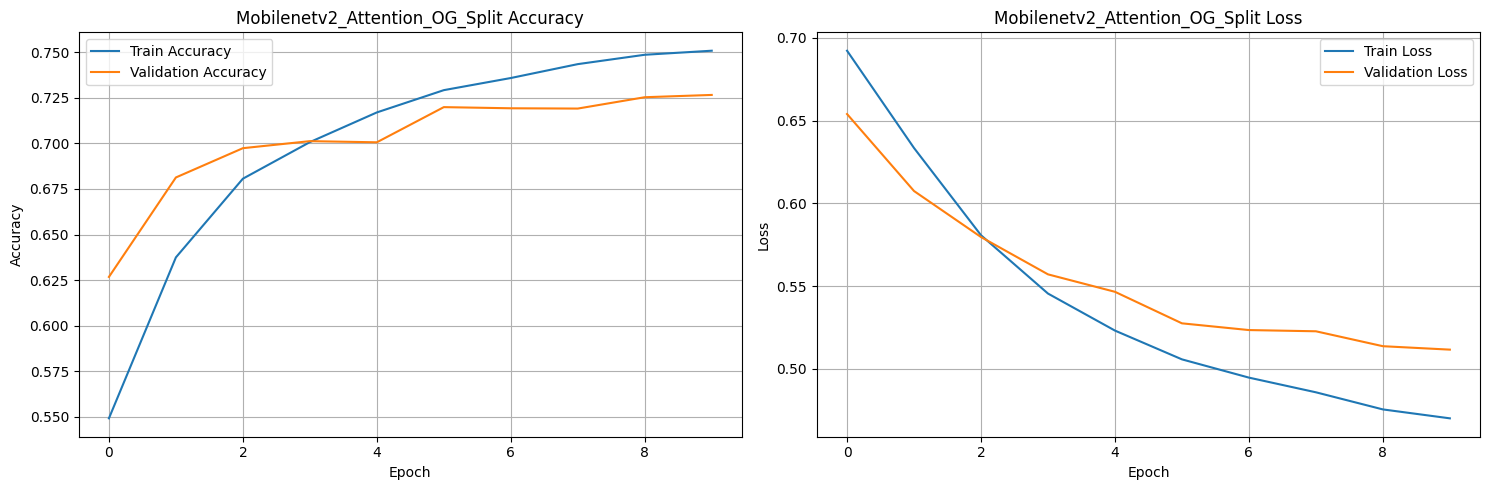

In [12]:
base_model_name_str = 'mobilenetv2'
model_name = f"{base_model_name_str.capitalize()}_Attention_OG_Split"
print(f"\n--- Training {model_name} ---")

model_mobilenet_att = build_attention_model(base_model_name=base_model_name_str)

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.keras")
callbacks_att = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
]

history_mobilenet_att = model_mobilenet_att.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_att,
    class_weight=class_weights,
    verbose=1
)

print(f"\nLoading best model for {model_name} from {checkpoint_path}")
best_model_mobilenet_att = load_model(checkpoint_path)
report_mobilenet_att = evaluate_model(best_model_mobilenet_att, val_generator, eval_steps, y_true_eval, model_name)
plot_training_history(history_mobilenet_att, model_name)

### 8.2 ResNet152V2 + Attention


--- Training Resnet152v2_Attention_OG_Split ---
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.5522 - loss: 0.7135
Epoch 1: val_loss improved from inf to 0.67233, saving model to checkpoints_sequential_og_split/Resnet152v2_Attention_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 297s 682ms/step - accuracy: 0.5522 - loss: 0.7134 - val_accuracy: 0.5803 - val_loss: 0.6723 - learning_rate: 1.0000e-04
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.6405 - loss: 0.6295
Epoch 2: val_loss improved from 0.67233 to 0.60551, saving model to checkpoints_sequential_og_split/Resnet152v2_Attention_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 250s 630ms/step - accuracy: 0.6405 - loss: 0.6294 - val_accuracy: 0.6518 - val_loss: 0.6055 - learning_rate: 1.0000e-04
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.6916 - loss: 0.5869
Epoch 3: val_loss improved from 0.60551 to 0.56283, saving model to checkpoints_sequential_og_split/Resnet152v2_Attention_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 24

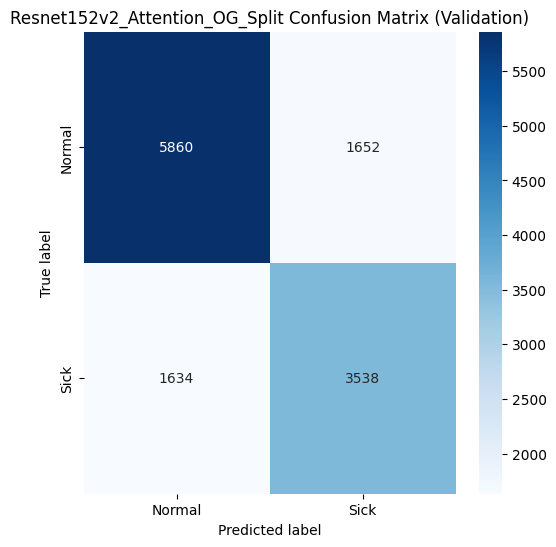

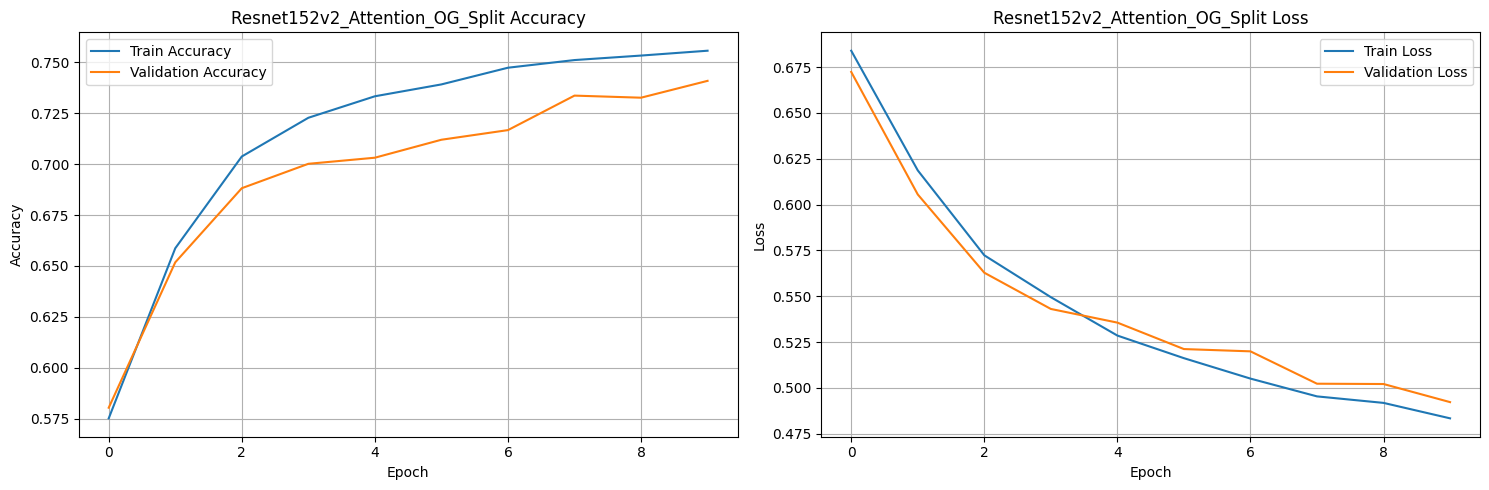

In [8]:
base_model_name_str = 'resnet152v2'
model_name = f"{base_model_name_str.capitalize()}_Attention_OG_Split"
print(f"\n--- Training {model_name} ---")

model_resnet_att = build_attention_model(base_model_name=base_model_name_str)

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.keras")
callbacks_att = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
]

history_resnet_att = model_resnet_att.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_att,
    class_weight=class_weights,
    verbose=1
)

print(f"\nLoading best model for {model_name} from {checkpoint_path}")
best_model_resnet_att = load_model(checkpoint_path)
report_resnet_att = evaluate_model(best_model_resnet_att, val_generator, eval_steps, y_true_eval, model_name)
plot_training_history(history_resnet_att, model_name)

### 8.3 DenseNet201 + Attention


--- Training Densenet201_Attention_OG_Split ---
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.5555 - loss: 0.6988
Epoch 1: val_loss improved from inf to 0.64525, saving model to checkpoints_sequential_og_split/Densenet201_Attention_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 348s 768ms/step - accuracy: 0.5555 - loss: 0.6988 - val_accuracy: 0.6403 - val_loss: 0.6453 - learning_rate: 1.0000e-04
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.6455 - loss: 0.6239
Epoch 2: val_loss improved from 0.64525 to 0.59259, saving model to checkpoints_sequential_og_split/Densenet201_Attention_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 251s 631ms/step - accuracy: 0.6455 - loss: 0.6238 - val_accuracy: 0.6591 - val_loss: 0.5926 - learning_rate: 1.0000e-04
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6933 - loss: 0.5605
Epoch 3: val_loss improved from 0.59259 to 0.56414, saving model to 

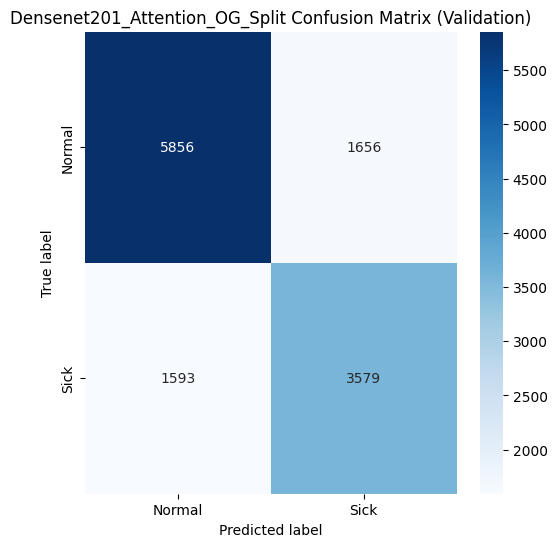

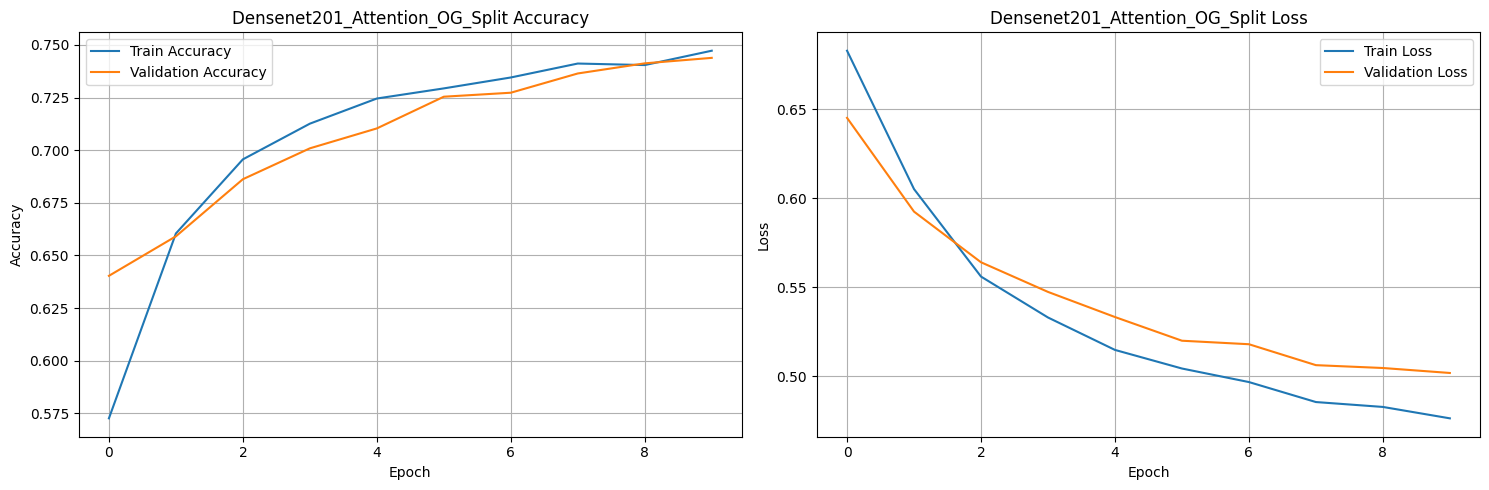

In [9]:
base_model_name_str = 'densenet201'
model_name = f"{base_model_name_str.capitalize()}_Attention_OG_Split"
print(f"\n--- Training {model_name} ---")

model_densenet_att = build_attention_model(base_model_name=base_model_name_str)

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.keras")
callbacks_att = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
]

history_densenet_att = model_densenet_att.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_att,
    class_weight=class_weights,
    verbose=1
)

print(f"\nLoading best model for {model_name} from {checkpoint_path}")
best_model_densenet_att = load_model(checkpoint_path)
report_densenet_att = evaluate_model(best_model_densenet_att, val_generator, eval_steps, y_true_eval, model_name)
plot_training_history(history_densenet_att, model_name)

### 8.4 InceptionV3 + Attention


--- Training Inceptionv3_Attention_OG_Split ---
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.4949 - loss: 0.7902
Epoch 1: val_loss improved from inf to 0.69303, saving model to checkpoints_sequential_og_split/Inceptionv3_Attention_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 280s 669ms/step - accuracy: 0.4950 - loss: 0.7900 - val_accuracy: 0.5371 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.5492 - loss: 0.6920
Epoch 2: val_loss improved from 0.69303 to 0.69226, saving model to checkpoints_sequential_og_split/Inceptionv3_Attention_OG_Split.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 248s 626ms/step - accuracy: 0.5492 - loss: 0.6920 - val_accuracy: 0.5612 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.5561 - loss: 0.6929
Epoch 3: val_loss improved from 0.69226 to 0.67676, saving model to 

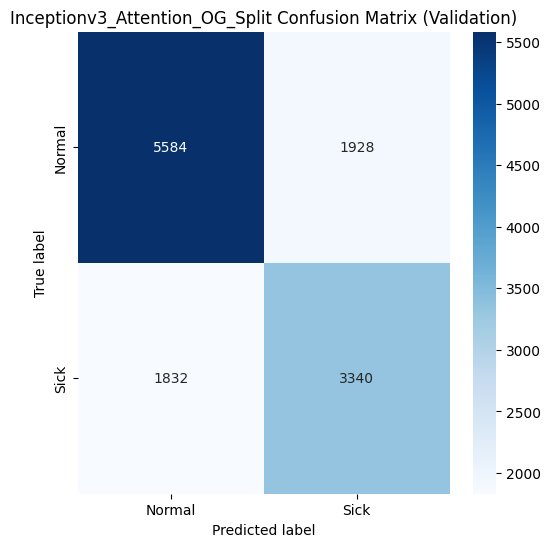

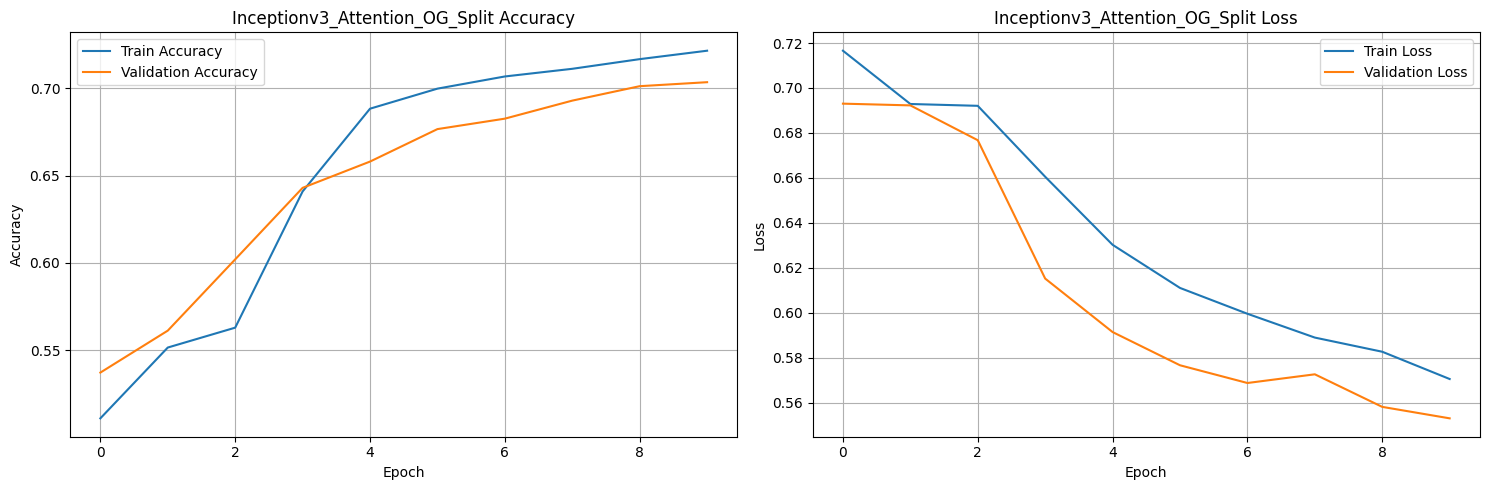

In [10]:
base_model_name_str = 'inceptionv3'
model_name = f"{base_model_name_str.capitalize()}_Attention_OG_Split"
print(f"\n--- Training {model_name} ---")

model_inception_att = build_attention_model(base_model_name=base_model_name_str)

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.keras")
callbacks_att = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
]

history_inception_att = model_inception_att.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_att,
    class_weight=class_weights,
    verbose=1
)

print(f"\nLoading best model for {model_name} from {checkpoint_path}")
best_model_inception_att = load_model(checkpoint_path)
report_inception_att = evaluate_model(best_model_inception_att, val_generator, eval_steps, y_true_eval, model_name)
plot_training_history(history_inception_att, model_name)

## 9. Ensemble Learning (Averaging Attention Models)
*Evaluates ensemble on the validation set.*


--- Creating Ensemble: Attention_Ensemble_OG_Split ---
Loading model: checkpoints_sequential_og_split/Mobilenetv2_Attention_OG_Split.keras
Loading model: checkpoints_sequential_og_split/Resnet152v2_Attention_OG_Split.keras
Loading model: checkpoints_sequential_og_split/Densenet201_Attention_OG_Split.keras
Loading model: checkpoints_sequential_og_split/Inceptionv3_Attention_OG_Split.keras
Predicting with model 1/4...
Predicting with model 2/4...
Predicting with model 3/4...
Predicting with model 4/4...
Averaging predictions...

Ensemble Classification Report (Validation Set):
              precision    recall  f1-score   support

      Normal       0.82      0.80      0.81      7512
        Sick       0.72      0.74      0.73      5172

    accuracy                           0.78     12684
   macro avg       0.77      0.77      0.77     12684
weighted avg       0.78      0.78      0.78     12684

Ensemble Accuracy: 0.7780
Ensemble Balanced Accuracy: 0.7722


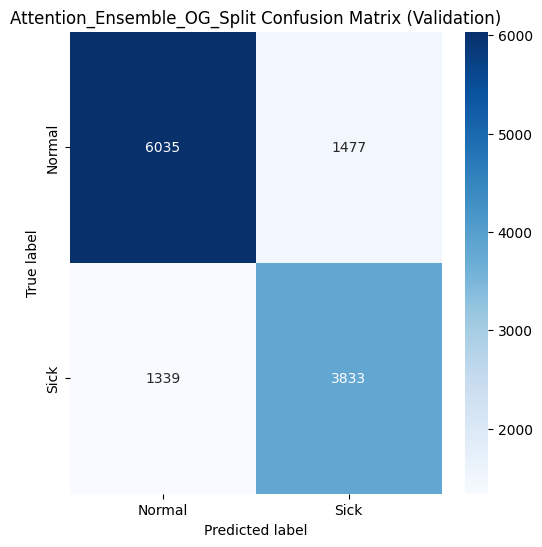

In [11]:
def create_ensemble(model_paths, eval_gen, eval_steps, y_true, ensemble_name):
    """Creates an ensemble model by averaging predictions."""
    print(f"\n--- Creating Ensemble: {ensemble_name} ---")
    models = []
    for path in model_paths:
        if os.path.exists(path):
             print(f"Loading model: {path}")
             models.append(load_model(path, compile=True))
        else:
            print(f"Warning: Model path not found - {path}. Skipping.")

    if not models:
        print("Error: No models loaded for ensemble.")
        results_summary[ensemble_name] = {'Error': 'No models found'}
        return None

    all_predictions = []
    eval_gen.reset()
    for i, model in enumerate(models):
        print(f"Predicting with model {i+1}/{len(models)}...")
        eval_gen.reset()
        preds = model.predict(eval_gen, steps=eval_steps, verbose=0)
        all_predictions.append(preds)

    if all_predictions:
        print("Averaging predictions...")
        ensemble_preds_prob = np.mean(all_predictions, axis=0)
        y_pred = (ensemble_preds_prob > 0.5).astype(int).flatten()

        if len(y_pred) > len(y_true):
            y_pred = y_pred[:len(y_true)]

        print("\nEnsemble Classification Report (Validation Set):")
        class_names = list(eval_gen.class_indices.keys())
        report_str = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        print(report_str)

        accuracy = report_dict['accuracy']
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
        print(f"Ensemble Accuracy: {accuracy:.4f}")
        print(f"Ensemble Balanced Accuracy: {balanced_acc:.4f}")

        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, class_names, title=f'{ensemble_name} Confusion Matrix (Validation)')

        results_summary[ensemble_name] = {
            'Accuracy': accuracy,
            'Balanced Accuracy': balanced_acc,
            'Loss': 'N/A',
            'Precision (Normal)': report_dict['Normal']['precision'],
            'Recall (Normal)': report_dict['Normal']['recall'],
            'F1-Score (Normal)': report_dict['Normal']['f1-score'],
            'Precision (Sick)': report_dict['Sick']['precision'],
            'Recall (Sick)': report_dict['Sick']['recall'],
            'F1-Score (Sick)': report_dict['Sick']['f1-score']
        }
        return report_dict
    else:
        print("No predictions generated for ensemble.")
        results_summary[ensemble_name] = {'Error': 'No predictions generated'}
        return None

# --- Define paths for the best ATTENTION models (OG Split) ---
attention_model_paths_og = [
    os.path.join(CHECKPOINT_DIR, "Mobilenetv2_Attention_OG_Split.keras"),
    os.path.join(CHECKPOINT_DIR, "Resnet152v2_Attention_OG_Split.keras"),
    os.path.join(CHECKPOINT_DIR, "Densenet201_Attention_OG_Split.keras"),
    os.path.join(CHECKPOINT_DIR, "Inceptionv3_Attention_OG_Split.keras"),
]

# --- Create and evaluate the ensemble on the VALIDATION SET ---
ensemble_report = create_ensemble(
    attention_model_paths_og,
    val_generator, # Use validation generator for evaluation
    eval_steps,    # Use validation steps
    y_true_eval,   # Use validation true labels
    "Attention_Ensemble_OG_Split"
)

## 10. Results Summary
*Displays collected metrics for all trained models and the ensemble.*

In [12]:
print("\n--- Overall Results Summary (OG Split Method) ---")
results_df = pd.DataFrame.from_dict(results_summary, orient='index')

# Define desired column order
cols_order = [
    'Accuracy', 'Balanced Accuracy', 'Loss',
    'Precision (Normal)', 'Recall (Normal)', 'F1-Score (Normal)',
    'Precision (Sick)', 'Recall (Sick)', 'F1-Score (Sick)',
    'Error' # Keep error column at the end if it exists
]
# Ensure all expected columns exist, add missing ones with NaN
for col in cols_order:
    if col not in results_df.columns:
        results_df[col] = np.nan

# Reorder columns
results_df = results_df[cols_order]

# --- Corrected Format Dictionary ---
# Create a dictionary of lambda functions for formatting
na_rep_str = 'N/A' # Define the representation for NaN

format_dict = {}
for col in results_df.columns:
    if results_df[col].dtype in [np.float64, np.int64]:
        # General formatter for float/int, handles NaN
        format_dict[col] = lambda x, fmt='{:.4f}': fmt.format(x) if not pd.isna(x) else na_rep_str
    # Keep other columns (like 'Error') unformatted for now, or add specific formatters if needed

# Specific formatter for 'Loss' to handle potential string 'N/A' as well as NaN
format_dict['Loss'] = lambda x: f'{x:.4f}' if isinstance(x, (int, float)) and not pd.isna(x) else na_rep_str

# --- Pandas Display Options ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- Print Formatted DataFrame ---
print(results_df.to_string(formatters=format_dict, na_rep=na_rep_str))


--- Overall Results Summary (OG Split Method) ---
                               Accuracy Balanced Accuracy    Loss Precision (Normal) Recall (Normal) F1-Score (Normal) Precision (Sick) Recall (Sick) F1-Score (Sick) Error
Resnet152v2_Attention_OG_Split   0.7409            0.7321  0.4923             0.7820          0.7801            0.7810           0.6817        0.6841          0.6829   N/A
Densenet201_Attention_OG_Split   0.7439            0.7358  0.5020             0.7861          0.7796            0.7828           0.6837        0.6920          0.6878   N/A
Inceptionv3_Attention_OG_Split   0.7036            0.6946  0.5530             0.7530          0.7433            0.7481           0.6340        0.6458          0.6398   N/A
Attention_Ensemble_OG_Split      0.7780            0.7722     N/A             0.8184          0.8034            0.8108           0.7218        0.7411          0.7313   N/A


## 11. Zip and Download Results

In [13]:
import os
import zipfile
from google.colab import files
import glob

# --- Configuration ---
ZIP_FILENAME = 'cardiac_mri_results.zip'
# CHECKPOINT_DIR is already defined from Cell 1
PLOT_DIR = '.' # Assuming plots are saved in the current directory

print(f"Preparing to zip results...")

# --- Find files to include ---
model_files = glob.glob(os.path.join(CHECKPOINT_DIR, '*.keras'))
plot_files = glob.glob(os.path.join(PLOT_DIR, '*_training_history.png')) # Specific naming convention

all_files_to_zip = model_files + plot_files

if not all_files_to_zip:
    print("No .keras models or .png plot files found to zip.")
else:
    print(f"Found {len(model_files)} model files and {len(plot_files)} plot files.")

    # --- Create the zip archive ---
    try:
        with zipfile.ZipFile(ZIP_FILENAME, 'w') as zipf:
            for file_path in all_files_to_zip:
                # Add file to zip using its base name to avoid deep directory structures
                arcname = os.path.basename(file_path)
                zipf.write(file_path, arcname=arcname)
                print(f"  Added: {arcname}")

        print(f"\nSuccessfully created zip file: {ZIP_FILENAME}")

        # --- Trigger download ---
        print("Starting download...")
        files.download(ZIP_FILENAME)
        print("Download initiated. Please check your browser.")

    except Exception as e:
        print(f"\nAn error occurred during zipping or download: {e}")

# Clean up the zip file from Colab environment after download (optional)
# try:
#     os.remove(ZIP_FILENAME)
#     print(f"Removed local zip file: {ZIP_FILENAME}")
# except OSError as e:
#     print(f"Error removing local zip file: {e}")


Preparing to zip results...
Found 8 model files and 8 plot files.
  Added: ResNet152V2_Baseline_OG_Split.keras
  Added: Densenet201_Attention_OG_Split.keras
  Added: Resnet152v2_Attention_OG_Split.keras
  Added: Mobilenetv2_Attention_OG_Split.keras
  Added: MobileNetV2_Baseline_OG_Split.keras
  Added: InceptionV3_Baseline_OG_Split.keras
  Added: Inceptionv3_Attention_OG_Split.keras
  Added: DenseNet201_Baseline_OG_Split.keras
  Added: MobileNetV2_Baseline_OG_Split_training_history.png
  Added: Densenet201_Attention_OG_Split_training_history.png
  Added: ResNet152V2_Baseline_OG_Split_training_history.png
  Added: Mobilenetv2_Attention_OG_Split_training_history.png
  Added: InceptionV3_Baseline_OG_Split_training_history.png
  Added: DenseNet201_Baseline_OG_Split_training_history.png
  Added: Inceptionv3_Attention_OG_Split_training_history.png
  Added: Resnet152v2_Attention_OG_Split_training_history.png

Successfully created zip file: cardiac_mri_results.zip
Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated. Please check your browser.
